# Lab 09: MLB Swing Probability Modeling

---
author: Alejandra Arias
date: April 8, 2024
embed-resources: true
---

## Introduction

In this report, we developed a well calibrated probability model that estimates the probability of inducing a batter to swing given the characteristics of a pitch thrown, in addiiton to other information such as the game situation for a particular pitcher. The dataset used in this report is the "Pitch Type Data" dataset from the [Statcast](https://baseballsavant.mlb.com/about) database. The dataset contains information about the pitch velocity, the swing, pitch movement, and pitch location thrown by a pitcher. This report will develop a model that will estimate the probability that a batter will swing at a pitch given the characteristics of the pitch and the game situation.

### Goal

The goal of this report is to develop a model that estimates the probability of a batter swinging at a pitch given the characteristics of the pitch and the game situation. The model will be evaluated using a function that calculated Expected Calibration error, which is essentially ana verage of the distance the points in a calibration plot are from the "perfect" line, and maximum calibration error which esentially the furthest any point in a calibration plot is from the "perfect" line.

## Methods

In [25]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

### Data

In [26]:
# load data
pitches_train = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-train.csv",
)
pitches_test = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-test.csv",
)

In [27]:
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

## Source
---
The original source of the data is [Statcast](https://en.m.wikipedia.org/wiki/Statcast), a database that collects detailed information about every pitch thrown in the MLB. Specifically, the [pybaseball](https://pypi.org/project/pybaseball/) library was used to extract the data for Zac Gallen from the 2023 MLB season.

## Data Dictionary

Each observation in the train, test, and production data contains information about a single pitch thrown by Shohei Ohtani in either 2022 which is the train data, 2023 which is the test data, or 2024 which is the production data. 

Here, the train-test split is based on time:
- Train: (2023-03-30 to 2023-08-30)
- Test: (2023-10-03 to 2023-11-01)

This original documentation for statcast data can be found [here](https://baseballsavant.mlb.com/csv-docs).

The data contains the following columns:

### Response
**`pitch_name`**

- `[int64]` The name of the pitch type to be thrown

### Features
**`release_spin_rate`**

- `[float64]` pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher's hand

**`release_speed`**

- `[float64]` Velocity of the pitch thrown.

**`spin_axis`**

- `[float64]` The spin axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.

**`plate_x`**

- `[float64]` Horizontal position of the ball when it crosses home plate from the catcher’s perspective.

**`plate_z`**

- `[float64]` Vertical position of the ball when it crosses home plate from the catcher’s perspective.

**`release_extension`**

- `[float64]` Release extension of pitch in feet as tracked by Statcast.

**~release_pos_x~**

- `[float64]` Horizontal Release Position of the ball measured in feet from the catcher’s perspective.

**~release_pos_y~**

- `[float64]` Release position of pitch measured in feet from the catcher’s perspective.

**`release_pos_z`**

- `[float64]` Vertical Release Position of the ball measured in feet from the catcher’s perspective.
    
**`pfx_x`**

- `[float64]` horiznotal movement (feet) of the pitch from the catcher's perspective

**`pfx_z`**

- `[float64]` vertical movement (feet) of the pitch from the catcher's perspective

**`stand`**

- `[object]` side of the plate batter is standing, either `L` (left) or `R` (right)

**`balls`**

- `[int64]` Pre-pitch number of balls in count.

**`strikes`**

- `[int64] `Pre-pitch number of strikes in count.

**`on_3b`**

- `[int64]` Pre-pitch MLB Player Id of Runner on 3B.

**`on_2b`**

- `[int64]` Pre-pitch MLB Player Id of Runner on 2B.

**`on_1b`**

- `[int64]` Pre-pitch MLB Player Id of Runner on 1B.

**`outs_when_up`**

- `[int64]` Pre-pitch number of outs.


In [28]:
# summary statistics
samples = len(pitches_train)
features = len(pitches_train.columns)
samples, features

(2653, 22)

In [29]:
swungdf = pitches_train[pitches_train["swing"] == 1]
swungdf.groupby("pitch_name").agg({"swing": "count"}) / pitches_train.groupby("pitch_name").agg({"swing": "count"})

,swing
pitch_name,
4-Seam Fastball,0.471451
Changeup,0.536313
Cutter,0.453782
Knuckle Curve,0.462875
Slider,0.492188


In [30]:
len(swungdf) / len(pitches_train)

0.47757255936675463

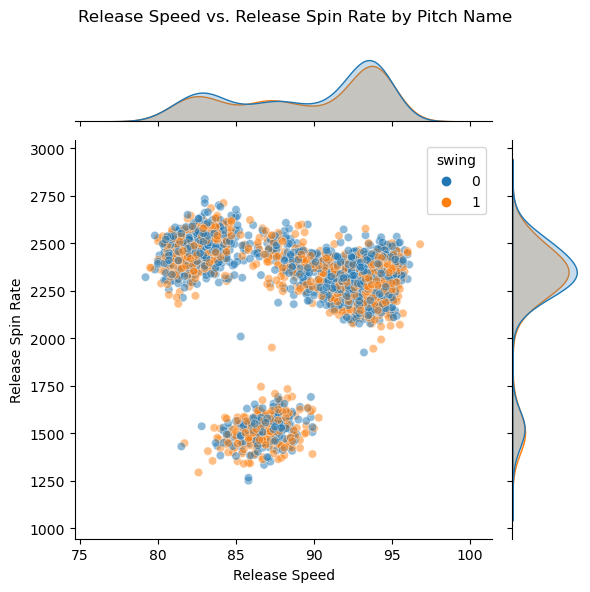

In [31]:
# visualizations
plot = sns.jointplot(data=pitches_train, x='release_speed', y='release_spin_rate', hue='swing', alpha=0.5)

plot.set_axis_labels('Release Speed', 'Release Spin Rate')
plot.fig.suptitle('Release Speed vs. Release Spin Rate by Pitch Name')
plot.fig.tight_layout()


plot.fig.subplots_adjust(top=0.9)
plt.show()

The jointplot below shows the relationship between the `release_spin_rate` and `release_speed` features in the dataset with the `swing` response. There appears to not be a string linear relationship between the `release_spin_rate` and `release_speed` features with the `swing` response. The clusters can indicate that other features might drive the relationship.

### Models

In [32]:
# process data for ML
# Preprocessing
numerical_features = [
    "release_extension", "release_pos_x", "release_pos_y", "release_pos_z",
    "release_speed", "release_spin_rate", "spin_axis", "plate_x", "plate_z",
    "pfx_x", "pfx_z", "balls", "strikes", "sz_top", "sz_bot"
]
categorical_features = ["pitch_name", "stand"]

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [33]:
# train models
# Base model and calibration
base_model = GradientBoostingClassifier(random_state=42)
calibrated_model = CalibratedClassifierCV(estimator=base_model, method="sigmoid", cv=5)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", calibrated_model)
])

# Hyperparameter tuning
param_grid = {
    "model__estimator__n_estimators": [100, 200],
    "model__estimator__learning_rate": [0.01, 0.1, 0.15],
    "model__estimator__max_depth": [1,3, 5]
}

mod = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_log_loss", verbose=1)
mod.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_extension',
                                                                          'release_pos_x',
                                                                          'release_pos_y',
                                                                          'release_pos_z',
                                                                          'release_speed',
                                                                          'release_spin_rate',
                                                                          'spin_axis',
                                                                          'plate_x',
                                                                          'plate_z',
                                                                          'pfx_x',
                                                                          'pfx_z',
                                                                          'balls',
                                                                          'strikes',
                                                                          'sz_to...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['pitch_name',
                                                                          'stand'])])),
                                       ('model',
                                        CalibratedClassifierCV(cv=5,
                                                               estimator=GradientBoostingClassifier(random_state=42)))]),
             param_grid={'model__estimator__learning_rate': [0.01, 0.1, 0.15],
                         'model__estimator__max_depth': [1, 3, 5],
                         'model__estimator__n_estimators': [100, 200]},
             scoring='neg_log_loss', verbose=1)

To develop the probability model, we will use a base model and a calibrated model classifier. The base model is a Gradient Boosting classifer used in the CalibratedClassifierCV function to calibrate the model. The preprocessor imputes the numerical and categorical variables as necessary.  

## Results

In [34]:
# report model metrics
y_pred = mod.predict(X_test)
test_calibration = calibration_error(y_test, y_pred)
max_calibration = calibration_error(y_test, y_pred, type='max')
print("Test calibration error: ", test_calibration)
print("Max calibration error: ", max_calibration)

Test calibration error:  0.2617801047120419
Max calibration error:  0.2906976744186046


In [35]:
mod.best_params_

{'model__estimator__learning_rate': 0.1,
 'model__estimator__max_depth': 3,
 'model__estimator__n_estimators': 200}

In [36]:
# required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


# function to calculate the calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=10):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)

    return calibration_error


# function to plot a calibration_plot
def plot_calibration_plot(y_true, y_prob):

    # generate "data" for calibration plot
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_prob,
        n_bins=10,
        pos_label=1,
    )

    # create a figure and axis object with a specific size
    fig, ax = plt.subplots()

    # plot the calibration curve
    ax.plot(
        prob_pred,
        prob_true,
        "s-",
        label="Learned Classifier",
        color="#1D58A7",
    )

    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="#F5821E",
    )

    # set the plot title and axis labels
    ax.set_title("Calibration Plot")
    ax.set_xlabel("Mean Predicted Value")
    ax.set_ylabel("Fraction of Positives")

    # add a grid
    ax.grid(
        True,
        color="lightgrey",
        linewidth=0.75,
        linestyle="--",
    )

    # fix aspect ratio
    ax.set_aspect(
        "equal",
        adjustable="box",
    )

    # show the legend
    ax.legend()

    # show the plot
    plt.show()


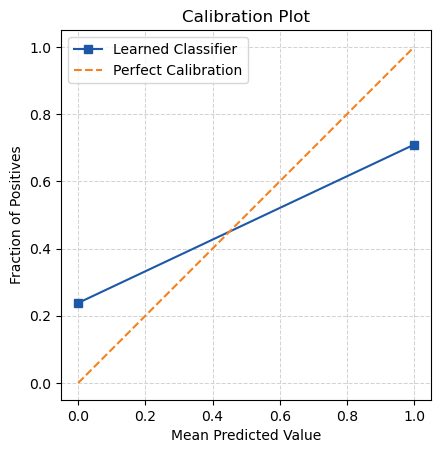

In [37]:
plot_calibration_plot(y_test,y_pred)

Based on the calibration plot, we see that our learned classifier is not as well calibrated but not compltely off the perfect calibration. Both our test and max calibration were in the same range of 0.26 and 0.29 respectively. Our calibration model performed moderately well, but there is room for improvement, especially at higher probabilities as it is underconfident compared to lower probabilities. Calibration techniques like platt scaling isotonic regression could be applied to improve the alignment of predicted probabilities with the true probabilities. This is espcially useful if accurate probability estimates are critical for decision-making.

## Discussion

If we were to use this Calibrated model in practice for different pitchers and pitch types, we would be moderately confident in the probability estimates. However, we would need to further calibrate the model to improve the alignment of predicted probabilities with the true probabilities. This would be especially important if accurate probability estimates are critical for decision-making, which in this case is applicable to the MLB. If we were to use this model as an MLB coach we would modify the following variables to improve the model: release_spin_rate, release_speed, spin_axis, plate_x, plate_z, release_extension, release_pos_z, pfx_x, pfx_z, stand, balls, strikes, on_3b, on_2b, on_1b, outs_when_up. This is because these variables are the most important in determining the probability of a batter swinging at a pitch, as seen in our model.

If used in practice, the model could be used to predict the probability of a batter swinging at a pitch given the characteristics of the pitch and the game situation. This could be used to inform the pitcher on what type of pitch to throw in a given situation to maximize the probability of inducing a swing. This could be especially useful in high-pressure situations where the outcome of the game is on the line. However, this model would not be helpful in higher pressure situations as it is underconfident, according to our calibration plot.

### Conclusion

Our model's ability to c;assify the probability of a batter swinging at a pitch given the characteristics of the pitch and the game situation is moderately well calibrated. However, there is room for improvement, especially at higher probabilities. This model could be used in practice to inform the pitcher on what type of pitch to throw in a given situation to maximize the probability of inducing a swing. However, in real-world high stress situations it would not be recommended to use this model. It would be helpful to use this model as a starting point so in future use cases a better model is developed with more appropriate calibration techniques. It would also be helpful to consider other pitcher and batter characteristics that could influence the probability of a batter swinging at a pitch.